# **PEC 0**

# **Setup**

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
TF_USE_LEGACY_KERAS=True

Vamos a crear la carpeta `images/ann` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras en alta resolución para el libro:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Definimos la siguiente función para limpiar la sesión después de cada entrenamiento del modelo.

In [3]:
def clean_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

Definimos una función auxiliar para ver la tasa de aprendizaje en cada punto.

In [4]:
def view_learning_rate(expon_lr_default):
    plt.figure(figsize=(5, 3))
    plt.plot(expon_lr_default.rates, expon_lr_default.losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(expon_lr_default.losses), min(expon_lr_default.rates), max(expon_lr_default.rates))
    plt.axis([min(expon_lr_default.rates), max(expon_lr_default.rates), 0, expon_lr_default.losses[0]])
    plt.grid()
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

    min_value = min(expon_lr_default.losses)
    print("El factor de perdida mas pequeno:", min(expon_lr_default.losses))
    index = expon_lr_default.losses.index(min_value)
    print("Factor de learning rate en el punto mas abajo:", expon_lr_default.rates[index])

Definimos una función para mostrar la accuracy.

In [63]:
def show_accuracy(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Graficar precisión y pérdida
  epochs = range(len(accuracy))

  plt.figure(figsize=(14, 5))

  # Gráfico de precisión
  plt.subplot(1, 2, 1)
  plt.plot(epochs, accuracy, 'bo-', label='Precisión en entrenamiento')
  plt.plot(epochs, val_accuracy, 'r-', label='Precisión en validación')
  plt.title('Precisión por época')
  plt.xlabel('Épocas')
  plt.ylabel('Precisión')
  plt.legend()

# **Revisión de los datos**

Cargamos el dataset ya dividido en train y test.

In [6]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Al igual que el conjunto de datos Fashion MNIST, el conjunto de entrenamiento MNIST contiene 60.000 imágenes en escala de grises, cada una de 28x28 píxeles:

In [7]:
X_train_full.shape

(60000, 28, 28)

La intensidad de cada píxel también se representa como un byte (de 0 a 255):

In [8]:
X_train_full.dtype

dtype('uint8')

Vamos a dividir el conjunto de entrenamiento completo en un conjunto de validación y un conjunto de entrenamiento (más pequeño). También reducimos las intensidades de los píxeles al rango 0-1 y las convertimos en flotantes, dividiéndolas por 255, igual que hicimos para Fashion MNIST:

In [9]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Vamos a mostrar una imagen de nuestro dataset, concretamente la imagen en la posicion 6 de la variable X_train_full

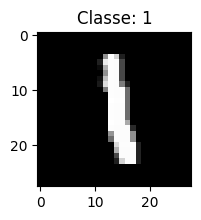

In [10]:
def show_example(id):
    plt.figure(figsize=(2, 2)) # Hacemos que la fotografia se vea mas pquena
    plt.imshow(X_train_full[id], cmap='gray')
    plt.title(f"Classe: {y_train_full[id]}")
    plt.show()

show_example(6)

Mostremos más datos aleatorios de nuestro conjunto de entrenamiento junto a su clase correspondiente.

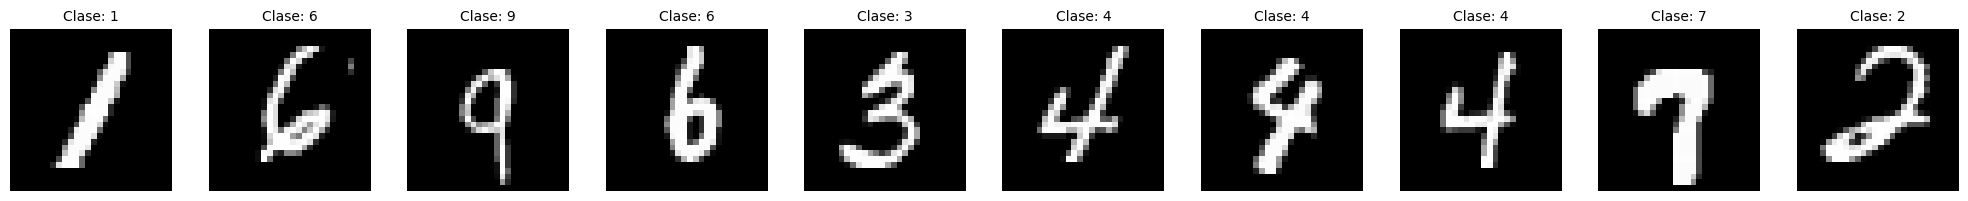

In [11]:
import random

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Pick random values from dataset
    random_value_from_dataset = random.randint(0, X_train_full.shape[0])
    ax = axes[i]
    ax.imshow(X_train_full[random_value_from_dataset], cmap='gray', interpolation='nearest')
    ax.set_title(f"Clase: {y_train_full[random_value_from_dataset]}", fontsize=10)
    ax.axis('off')  # Ocultar los ejes
plt.tight_layout()
plt.show()

En algunos datasets, la clase objetivo a predecir puede ser una categoría como "perro", "gato", etc. En estos casos, asignamos un valor numérico (INT) a cada clase para facilitar su procesamiento. Por ejemplo, mapeamos "perro" como clase 1 y "gato" como clase 2, lo cual permite que el modelo interprete las categorías de manera más eficiente.

Pero en este caso, podemos ver que nuestro y_train ya viene representado con esas clases que corresponden a los mismos numeros.

In [12]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

El conjunto de validación tiene 5,000 images, y el de test tiene 10,000 imagenes:

In [13]:
X_valid.shape

(5000, 28, 28)

In [14]:
X_test.shape

(10000, 28, 28)

Vamos a construir una red densa simple y encontrar la tasa de aprendizaje óptima. Necesitaremos una llamada de retorno para aumentar la tasa de aprendizaje en cada iteración. También registrará la tasa de aprendizaje y la pérdida en cada iteración:

# **Ejercicio del Libro**

A continuación, definiremos una clase de soporte llamada ExponentialLearningRate, que nos ayudará a ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento.

La idea principal es aumentar la tasa de aprendizaje después de cada batch de entrenamiento, aplicando un incremento gradual.

Al usar este callback, la tasa de aprendizaje se incrementará progresivamente con cada batch, lo cual es especialmente útil en las etapas iniciales del entrenamiento para acelerar el aprendizaje del modelo.

In [67]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [68]:
clean_session()

Definimos nuestro primer modelo con dos capas ocultas.
- La primera capa cuenta con 300 neuronas
- Mientras que la segunda tiene 100 neuronas.

In [69]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Empezaremos con un learning rate pequeno de 1e-3, y lo iremos incrementando un 0.5% en cada iteracion gracias a la clase que hemos hecho anteriormente ExponentialLearningRate.

In [70]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Ahora entrenaremos nuestro modelo por solo una ephoc.

In [71]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.5438 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


A continuación, observamos el desempeño de nuestro modelo después de una única época de entrenamiento.

El factor de perdida mas pequeno: 1.0117546319961548
Factor de learning rate en el punto mas abajo: 0.7563038903474807


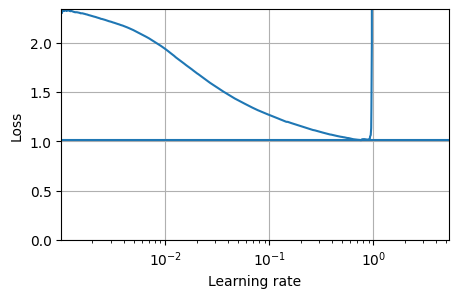

In [20]:
view_learning_rate(expon_lr)


Observamos que en las coordenadas Loss = 1.009 y Learning rate = 0.8 se produce un incremento abrupto. Esto ocurre porque, en ese punto, el algoritmo deja de aprender: probablemente el paso es demasiado grande y está superando el mínimo óptimo.

Para corregir esto, reduciremos el factor de la tasa de aprendizaje a la mitad, quedando en 0.4 (equivalente a 4e-1).

In [72]:
clean_session()

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
#optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
run_index = 1
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [74]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8664 - loss: 0.4164 - val_accuracy: 0.9662 - val_loss: 0.1138
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9677 - loss: 0.1065 - val_accuracy: 0.9740 - val_loss: 0.0933
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9790 - loss: 0.0695 - val_accuracy: 0.9744 - val_loss: 0.0903
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9839 - loss: 0.0495 - val_accuracy: 0.9778 - val_loss: 0.0835
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9886 - loss: 0.0368 - val_accuracy: 0.9772 - val_loss: 0.0880


In [58]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,612 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [75]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9717 - loss: 0.1008


[0.07907433062791824, 0.9782999753952026]

Podemos ver que hemos llegado a un 97 porciento de accuracy

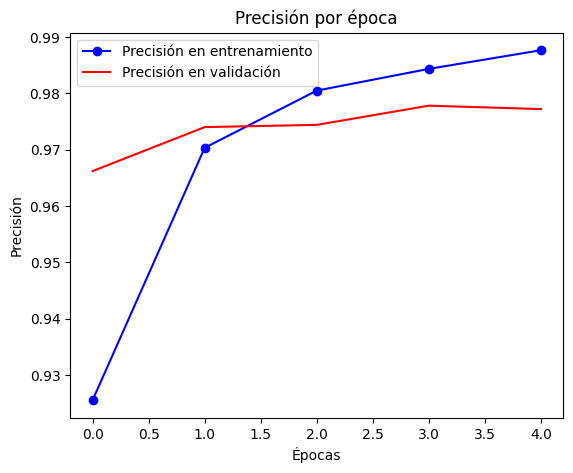

In [76]:
show_accuracy(history)

# **Red con 3 capas oculta**

In [26]:
clean_session()

En este modelo crearemos 3 capas ocultas:

*   La primera contiene 300 neuronas.
*   La segunda contiene 200 neuronas.
*   La tercera contiene 100 neuronas.



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.4619 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
El factor de perdida mas pequeno: 1.097905158996582
Factor de learning rate en el punto mas abajo: 0.8191308867931365


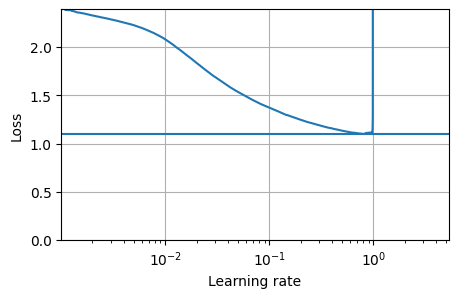

In [27]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3 = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer_3,
              metrics=["accuracy"])
expon_lr_3 = ExponentialLearningRate(factor=1.005)
history = model_3.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_3])
view_learning_rate(expon_lr_3)

Después de ejecutar varias veces y analizar el factor de learning rate adecuado, concluimos que obtenemos un promedio de 0.8. Por lo tanto, reduciremos este factor a la mitad para encontrar soluciones óptimas.

In [77]:
clean_session()

In [78]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3 = tf.keras.optimizers.SGD(learning_rate=4e-1)
model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_3,
              metrics=["accuracy"])
run_index = 2
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_3.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_3.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8398 - loss: 0.5071 - val_accuracy: 0.9620 - val_loss: 0.1219
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.9639 - loss: 0.1215 - val_accuracy: 0.9708 - val_loss: 0.1008
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9768 - loss: 0.0763 - val_accuracy: 0.9738 - val_loss: 0.0925
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9813 - loss: 0.0586 - val_accuracy: 0.9684 - val_loss: 0.1177
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9862 - loss: 0.0453 - val_accuracy: 0.9764 - val_loss: 0.0933


In [79]:
model_3 = tf.keras.models.load_model("my_mnist_model_3.keras")
model_3.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9668 - loss: 0.1059


[0.0869460254907608, 0.9722999930381775]

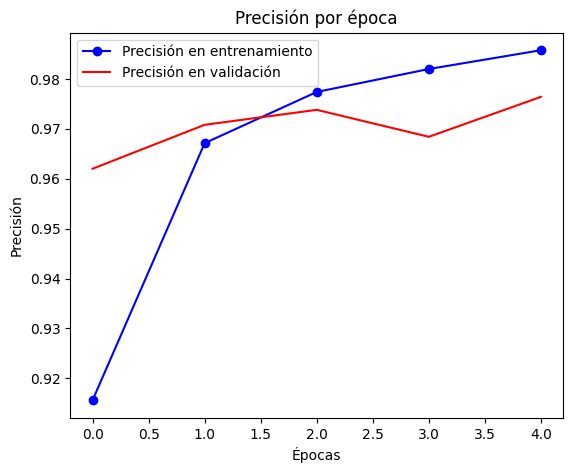

In [80]:
show_accuracy(history)

# **Red con 4 capas ocultas**

In [31]:
clean_session()

En este modelo crearemos 4 capas ocultas:

- La primera contiene 400 neuronas.
- La segunda contiene 300 neuronas.
- La tercera contiene 200 neuronas.
- La cuarta contiene 100 neuronas.

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - accuracy: 0.4664 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
El factor de perdida mas pequeno: 1.1295123100280762
Factor de learning rate en el punto mas abajo: 0.7017871311306952


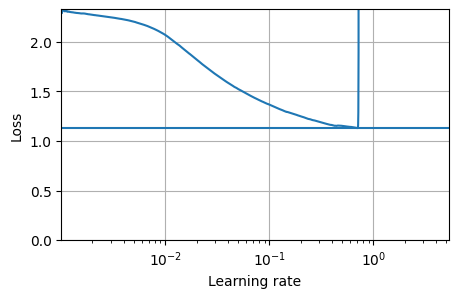

In [32]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(400, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_4 = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer_4,
              metrics=["accuracy"])
expon_lr_4 = ExponentialLearningRate(factor=1.005)
history = model_4.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_4])
view_learning_rate(expon_lr_4)

In [81]:
clean_session()

In [82]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(400, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_4 = tf.keras.optimizers.SGD(learning_rate=3e-1)
model_4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_4,
              metrics=["accuracy"])
run_index = 4
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_4.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_4.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7911 - loss: 0.6567 - val_accuracy: 0.9656 - val_loss: 0.1232
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9645 - loss: 0.1217 - val_accuracy: 0.9752 - val_loss: 0.0863
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9768 - loss: 0.0802 - val_accuracy: 0.9762 - val_loss: 0.0888
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9818 - loss: 0.0638 - val_accuracy: 0.9756 - val_loss: 0.0923
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.9845 - loss: 0.0488 - val_accuracy: 0.9764 - val_loss: 0.0763


In [83]:
model_4 = tf.keras.models.load_model("my_mnist_model_4.keras") # rollback to best model
model_4.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9722 - loss: 0.0999


[0.08330826461315155, 0.9768999814987183]

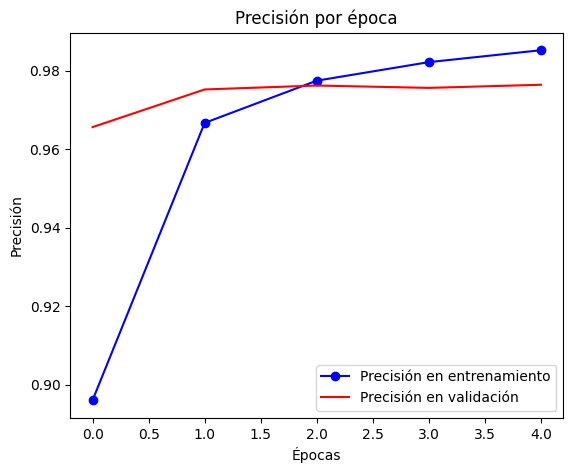

In [84]:
show_accuracy(history)

# **Comparación entre modelos**

En este apartado, realizaremos una comparación detallada de los tres modelos que he desarrollado. Para asegurar una evaluación justa, cada modelo ha sido entrenado durante 5 épocas, aunque en condiciones estándar se emplearían múltiples épocas para optimizar el rendimiento.

Esta limitación nos permite realizar una comparación más equilibrada y directa entre los modelos en cuanto a su rendimiento inicial. Además, al restringir el entrenamiento a una única época, podemos analizar con mayor precisión las métricas del learning rate en cada modelo, obteniendo así una visión más clara de sus respectivos comportamientos y diferencias en el proceso de aprendizaje.


### **Modelo base**
En el primer modelo, observamos una arquitectura sencilla con solo dos capas ocultas: la primera con 300 neuronas y la segunda con 100 neuronas. Al ajustar el learning rate y realizar un entrenamiento de una sola época, el modelo logra resolver el problema de manera satisfactoria. Esto se debe a la baja complejidad de la red, que cuenta con pocos parámetros y, por lo tanto, facilita el ajuste. Los resultados en las pruebas demuestran un desempeño notable, evidenciando que este modelo es capaz de generalizar adecuadamente incluso con un entrenamiento mínimo.



In [36]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9586 - loss: 0.1369


[0.11591673642396927, 0.9638000130653381]

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,612 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### **Modelo con 3 capas ocultas**
En el modelo con tres capas ocultas encontramos que la primera capa oculta es de 300, la segunda de 200 y la tercera de 100. Podemos que tras ajustar el valor del learning rate, es capaz tambien de con solo una ephoca, generalizar correctamente.

Pero si comparamos con el modelo de solo 2 capas ocultas, podemos observar que hay un ligero cambio en lo que ocupa la red. Mientras que en el primera red encontramos **266,612 parametros**, mientras que en esta encontramos **316,812 parametros**  

In [38]:
model_3 = tf.keras.models.load_model("my_mnist_model_3.keras")
model_3.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9625 - loss: 0.1256


[0.10747857391834259, 0.9682999849319458]

In [39]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,812 (1.21 MB)

 Trainable params: 316,810 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

En términos de rendimiento, ambos modelos muestran un comportamiento bastante similar. Sin embargo, optaríamos lógicamente por el primer modelo, ya que tiene una cantidad menor de parámetros, lo que lo hace más eficiente.

### Modelo de 4 capas ocultas

Este modelo presenta una arquitectura más extensa, con una primera capa de 400 neuronas, seguida de una segunda con 300, una tercera con 200, y una cuarta capa de 100 neuronas. A simple vista, parece que este modelo es excesivamente grande; si logramos resolver el problema de manera óptima con menos capas y neuronas, ¿por qué añadir complejidad innecesaria?

Al compararlo, notamos que, con una sola época de entrenamiento, este modelo no alcanza el mismo nivel de precisión que los otros dos, mostrando un rendimiento menos eficiente. Esta disminución en el accuracy puede atribuirse al aumento significativo en los parámetros: a diferencia del modelo con tres capas ocultas, esta red tiene **515,612 parámetros**, lo que hace el proceso de ajuste más demandante y menos efectivo.

Si entrenamos con más épocas, podríamos alcanzar el mismo nivel de precisión, pero hacerlo no tiene sentido.

In [40]:
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 400)                 │         314,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 300)                 │         120,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,612 (1.97 MB)

 Trainable params: 515,610 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Que pasa si la red de 3 capas tiene mas neuronas?
Si lo que hemos dicho es cierto, si creasemos una red de 3 capas ocultas con muchos mas parametros, obtendriamos unos resultados similares a los de la red 4.


In [87]:
clean_session()

In [89]:
model_5 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(4000, activation="relu"),
    tf.keras.layers.Dense(2000, activation="relu"),
    tf.keras.layers.Dense(1000, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_5 = tf.keras.optimizers.SGD(learning_rate=3e-1)
model_5.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_5,
              metrics=["accuracy"])
run_index = 5
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=1)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_5.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_5.fit(X_train, y_train, epochs=5,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 223s 129ms/step - accuracy: 0.8668 - loss: 0.4239 - val_accuracy: 0.9688 - val_loss: 0.1056
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 268s 133ms/step - accuracy: 0.9733 - loss: 0.0883 - val_accuracy: 0.9764 - val_loss: 0.0809
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 245s 123ms/step - accuracy: 0.9849 - loss: 0.0508 - val_accuracy: 0.9788 - val_loss: 0.0758
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 288s 138ms/step - accuracy: 0.9888 - loss: 0.0359 - val_accuracy: 0.9812 - val_loss: 0.0704
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 229s 119ms/step - accuracy: 0.9915 - loss: 0.0276 - val_accuracy: 0.9828 - val_loss: 0.0791


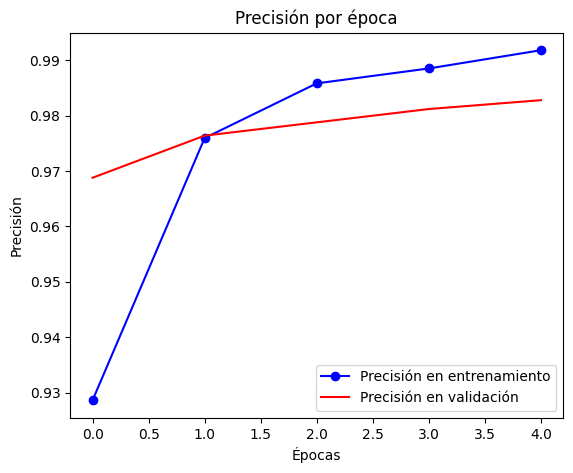

In [90]:
show_accuracy(history)

In [91]:
model_5 = tf.keras.models.load_model("my_mnist_model_5.keras")
model_5.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9738 - loss: 0.0919


[0.07042603939771652, 0.9786999821662903]

Podemos observar que hemos alcanzado un nivel de precisión bastante aceptable. Sin embargo, al comparar el tiempo de entrenamiento de este modelo con el de otros, la diferencia es notablemente significativa. Mientras que los otros modelos se entrenan en cuestión de segundos, hemos dedicado una cantidad considerable de tiempo a entrenar este modelo en particular. Esto pone de manifiesto que, aunque el rendimiento en términos de precisión es satisfactorio, la inversión de tiempo es desproporcionada en comparación con los resultados obtenidos por los otros enfoques.